<img src="https://www.digitalhouse.com/logo-DH.png" width="200" height="100" align="left">

<h3><b>Curso:</b> Data Science / <b>Año:</b> 2020 / <b>Sede:</b> Casa</h3>

-----

<h3><b>TP Integrador:</b> Text Mining de <i>tweets</i> de anuncios del gobierno durante la cuarentena.</h3>
<blockquote>
        <ul>
          <li><i>Sentiment analysis</i> de los comentarios de los usuarios.</li>
          <li>Clustering de <i>tweets</i> de los usuarios.</li>
        </ul>
</blockquote>

<h3><b>Grupo 10:</b></h3>
<blockquote>
        <ul>
          <li>Maria Eugenia Perotti</li>
          <li>Gastón Ortíz</li>
        </ul>
</blockquote>

# Sobre el trabajo.

Nuestra propuesta es realizar _text mining_ sobre tweets publicados durante la cuarentena, concentrándonos específicamente en las fechas en las que el presidente hace los anuncios relacionados al distanciamiento social preventivo y obligatorio.

## Criterios de búsqueda.
Debido al gran volumen de _tweets_ y a las limitaciones de la biblioteca que estamos utilizando, nos vimos forzados a limitar los criterios de búsqueda.

<b><u>Ciudades:</u></b>
* Buenos Aires
* Cordoba
* Rosario
* Mendoza
* Tucumán
* San Juan
* Neuquén
* Paraná
* Comodoro Rivadavia

<b><u>Cuentas:</u></b>
* Ministerio de Salud de la Nación | @msalnacion
* Casa Rosada | @CasaRosada
* Horacio Rodríguez Larreta | @horaciorlarreta
* Alberto Fernández | @alferdez
* Alberto Fernández Prensa | @alferdezprensa
* Axel Kicillof | @Kicillofok
* Cristina Kirchner | @CFKArgentina

<b><u>Hashtags:</u></b>
* #covid19
* #covid
* #coronavirus
* #cuarentena
* #albertofernandez

# Preparación de libraries y funciones.

## Configuración Colab.

In [3]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    !pip install GetOldTweets3
    !pip install unidecode
    ruta_drive = "/content/drive/My Drive/TP Integrador/Notebooks/Data/"
except ModuleNotFoundError:    
    print("Se está trabajando localmente")

Se está trabajando localmente


## Imports.

In [4]:
import numpy as np
import pandas as pd
import GetOldTweets3 as got
import datetime
from textblob import TextBlob
import re
import unidecode
import matplotlib.pyplot as plt
import time
import os
import glob


## Definición de funciones.
En esta sección definimos las funciones que vamos a utilizar en la notebook.

### Función para obtener los tweets de acuerdo a los criterios de búsqueda.

In [5]:
def get_tweets(list_criterios, fecha_inicio, fecha_final, maximo=250):
    tweets_total = []
    for criterio in list_criterios:
        tweetCriteria = got.manager.TweetCriteria().setQuerySearch(criterio).setSince(fecha_inicio).setUntil(fecha_final).setMaxTweets(maximo)
        tweets_total = got.manager.TweetManager.getTweets(tweetCriteria)
    return tweets_total

### Función para limpiar los tweets.

In [6]:
def limpiar(tweet_texto):
    text = ' '.join(re.sub(r"(@)|([^0-9A-Za-z \t])|(www.[^ ]+)|(https?://[^ ]+)", "", unidecode.unidecode(tweet_texto.lower())).split())
    return text

### Función para crear un dataframe en base a los tweets.

In [7]:
def create_df(tweets_anuncios):
    datos = []
    for anuncio in tweets_anuncios:
        for ciudad in tweets_anuncios[anuncio]: 
            for tweet in tweets_anuncios[anuncio][ciudad]:
                registro = {'username': tweet.username, 'tweet': limpiar(tweet.text), \
                            'fecha': tweet.date, 'anuncio':anuncio, 'ubicacion':ciudad, 'id':tweet.id}
                datos.append(registro)
    df = pd.DataFrame(data=datos)    
    return df

### Función para limpiar dataframe.

In [100]:
#definimos listas de los usuarios y topics que vamos a eliminar
usuarios_blacklist = ['sergistack', 'GamesRedDeer']
usuarios_medios = ['gustavorearte1','gerdellamonica','radiofonica1007',' pmgcharly',' NTodxs',' Noticiasde_',' nora_verges',' mnspezzapria',' METRO_RADIO_TV',' MartinD50004804',' mariogaloppo',' LUIS20GEREZ',' losprimerostuc',' lacriticaok',' lacapital',' IldefonsoM',' HernanMundo',' elsolquilmes',' ellitoral',' cronica',' cordoba',' Contexto_Tuc',' ConLaGenteRos',' con_sello',' Cadena3Com',' AvellanedaReal',' AiredeSantaFe',' AgenciaDib',' Adry1BC',' ADNsur',' abccordoba',' 104Urbana']
topicos_excluidos = ['uefa','pique','barcelona', 'bayern munich', 'barca', 'bayern', 'barsa', 'anabelle', 'annabell', 'annabelle', 'messi', 'balvin', 'pampita']

def clean_up_df(df):
    #definimos una máscara para excluir a los usuarios en la lista negra
    mask_not_bl = [x not in usuarios_blacklist for x in df['username']] 
    df = df[mask_not_bl]
    #definimos una máscara para excluir a los usuarios en la lista negra
    mask_not_media = [x not in usuarios_medios for x in df['username']] 
    df = df[mask_not_media]
    df.drop_duplicates(subset=['tweet'], keep=False, inplace=True)
    # máscara de tópicos excluidos
    mask_not_topics = [x not in topicos_excluidos for x in df['tweet']] 
    df = df[mask_not_topics]
    
    try:
        df.drop(columns=['index'], axis=0, inplace=True)
    except:
        print("No existe la columna index")
        
    try:
        df.drop(columns=['fecha_sola'], axis=0, inplace=True)
    except:
        print("No existe la columna fecha_sola")
        
    return df

# Obtención de tweets.
En esta sección definimos los criterios de búsqueda y ejecutamos las funciones descritas previamente.

## Llamado a la API para obtener los tweets.

Procedemos a declarar los parámetros que utilizaremos para las búsquedas:

In [9]:
fecha_inicio = ["2020-03-19T21:00:38Z","2020-03-29T20:00:38Z","2020-04-10T20:00:38Z","2020-04-25T18:00:38Z","2020-05-08T20:00:38Z","2020-05-23T20:00:38Z","2020-06-04T20:00:38Z","2020-06-26T18:00:38Z","2020-07-17T14:00:38Z","2020-07-31T14:00:38Z","2020-08-14T14:00:38Z"]
fecha_final =  ["2020-03-20T04:00:38Z","2020-03-30T04:00:38Z","2020-04-11T04:00:38Z","2020-04-26T04:00:38Z","2020-05-09T04:00:38Z","2020-05-24T04:00:38Z","2020-06-05T04:00:38Z","2020-06-27T04:00:38Z","2020-07-18T04:00:38Z","2020-08-01T04:00:38Z","2020-08-15T04:00:38Z"]
criterios = ["cuarentena","msalnacion","CasaRosada","alferdez", "alferdezprensa"]
#ciudades = ["Buenos Aires, Argentina"],"Cordoba, Argentina","Rosario, Argentina","Mendoza, Argentina", "Tucumán, Argentina","Paraná, Argentina"
#ciudades = ["Cordoba, Argentina"]
#ciudades = ["Rosario, Argentina"]
#ciudades = ["Mendoza, Argentina"]
#ciudades = ["Tucumán, Argentina"]
ciudades = ["Paraná, Argentina"]
#radio = "200km"
maximo = 300

Ejecutamos la función para traer los tweets:

In [10]:
dic_tweets = {}
for i in range(len(fecha_inicio)):
    dic_tweets["Anuncio_"+str(i+1)] = {}
    for ciudad in ciudades:
        try:
            dic_tweets["Anuncio_"+str(i+1)][ciudad] = get_tweets(criterios,fecha_inicio[i],fecha_final[i],maximo)
        except:
            continue
    print(i)

0
1
2
3
4
5
6
7
8
An error occured during an HTTP request: HTTP Error 429: Too Many Requests
Try to open in browser: https://twitter.com/search?q=alferdez%20since%3A2020-07-31T14%3A00%3A38Z%20until%3A2020-08-01T04%3A00%3A38Z&src=typd
9
An error occured during an HTTP request: HTTP Error 429: Too Many Requests
Try to open in browser: https://twitter.com/search?q=cuarentena%20since%3A2020-08-14T14%3A00%3A38Z%20until%3A2020-08-15T04%3A00%3A38Z&src=typd
10


### Creación del dataframe.

Ejecutamos la función para crear el dataframe y le pasamos como parámetros los tweets:

In [124]:
try:
    df = create_df(dic_tweets)
except:
    df = pd.read_csv('tweets_consolidados_1598826979.2961667.csv', sep=';')

Verificamos que haya creado exitosamente el dataframe:

In [125]:
df.head(3)

,username,tweet,fecha,anuncio,ubicacion,id
0,GonzaloBuxo,apoyo total las medidas fuerza presidente esta...,2020-03-19 23:59:45+00:00,Anuncio_1,"Paraná, Argentina",1240790092408672257
1,gacela2019,asi lo hacemos sr presidente,2020-03-19 23:58:50+00:00,Anuncio_1,"Paraná, Argentina",1240789862191685639
2,arielonnis,alferdez alferdezprensa necesitamos respuesta ...,2020-03-19 23:57:29+00:00,Anuncio_1,"Paraná, Argentina",1240789521425465344


In [126]:
df.shape

(2427, 6)

#### Creación de variable _target_: `sentimiento`.

Una vez que comprobamos que está todo OK, agregamos la columna sentimiento y procedemos a exportar los tweets a un .csv para preservar la muestra. Usamos como separador el `;` para que cuando lo abramos en Excel se divida automáticamente en columnas.

Crearemos la variable target para, posteriormente, poder realizar la clasificación. Por el momento estará vacía.

In [127]:
df['sentimiento'] = ''

#### Guardamos el dataset crudo.

Exportamos el dataset para combinarlo más adelante.

In [128]:
df.to_csv("Data/Crudos/tweets_crudos_"+str(time.time())+".csv", sep=';', index=False)

# Limpieza.

Tamaño del dataset previo a la limpieza:

In [154]:
df.shape

(19588, 8)

### Por usuarios específicos.

#### Trolls.

In [155]:
mask_bl = [x in usuarios_blacklist for x in df['username']] 

In [156]:
#definimos una máscara para excluir a los usuarios en la lista negra
mask_not_bl = [x not in usuarios_blacklist for x in df['username']] 
#pisamos el dataframe sin los usuarios de la lista negra
df = df[mask_not_bl]
df.shape[0]

19484

#### Medios de comunicación.

In [157]:
mask_media = [x in usuarios_medios for x in df['username']] 

In [158]:
#definimos una máscara para excluir a los usuarios en la lista negra
mask_not_media = [x not in usuarios_medios for x in df['username']] 
#pisamos el dataframe sin los usuarios de la lista negra
df = df[mask_not_media]
df.shape[0]

19438

### Por contenido de tweets.
#### Duplicados.

In [160]:
df.drop_duplicates(subset=['tweet'], keep=False, inplace=True)
df.shape[0]

7480

#### Tópicos no relevantes.

In [161]:
for t in topicos_excluidos:
    mask_topicos = df['tweet'].str.find(t) != -1
    
df.loc[mask_topicos, ['username','tweet']]

,username,tweet
455,ciudad_magazine,se activo el protocolo pampita debera hisopars...
781,elsolonline,coronavirus pampita debe hisoparse por un posi...
805,Enzopompili04,che corona virus primero te metiste con el tio...
1275,la100fm,coronavirus pampita se hizo el test porque una...
1395,LosAndesDiario,mas contagios en la tv pampita hizo su program...
2284,tiempodesanjuan,pampita se hizo el hisopado por coronavirus co...
722,emmariviello,hola pampitaoficial como sigue el tio de tu ma...
1306,LasdicRodro,alguien sabe como esta el tio del marido de pa...
1659,MFlorenciaN,debo ser la unica que se entero que el tio del...
2015,QueHacesNacho,ay saben que mi mama me hizo hoy una videollam...


In [162]:
for t in topicos_excluidos:
    mask_topicos_excluidos = df['tweet'].str.find(t) == -1
    
df = df[mask_topicos_excluidos]

In [163]:
df.shape

(7467, 8)

### Guardamos el dataset filtrado.

In [164]:
df.to_csv("Data/Crudos/tweets_crudos_limpios_"+str(time.time())+".csv", sep=';', index=False)

## Merge de datasets.

Con el fin de sumar la mayor cantidad de tweets, es necesario que vayamos armando el dataframe consolidado con los datos que vamos obteniendo de "a cachos".

Por esta razón, tenemos tres datasets:
1. Nuevos tweets obtenidos sin clasificar.
2. Tweets clasificados.
3. Dataframe ya consolidado con todos los tweets obtenidos hasta el momento.

### Datasets con archivo consolidado.

In [123]:
try:
    list_of_files = glob.glob('Data/Consolidado/*.csv') 
    latest_file = max(list_of_files, key=os.path.getctime)
    df_consolidado_nuevo = pd.read_csv(latest_file, sep=';')
except:
    print("No hay archivos en el directorio")

In [26]:
df_consolidado_nuevo.head()

,username,tweet,fecha,anuncio,ubicacion,id,sentimiento,fecha_sola
0,Elizabeth789741,alferdez alferdezprensa por favor qxsea a part...,2020-03-19 23:04:48+00:00,Anuncio_1,"Buenos Aires, Argentina",1.240776e+18,NaN,NaN
1,sergistack,usas google chrome lo siento por las mayuscula...,2020-03-28 20:07:18+00:00,Anuncio_1,"Buenos Aires, Argentina",1.243993e+18,NaN,NaN
2,vickyuliyapo,comodice inesazpelicueta que comiencen ya a el...,2020-03-19 22:57:33+00:00,Anuncio_1,"Buenos Aires, Argentina",1.240774e+18,NaN,NaN
3,RUCHOCASLA,alferdez alferdezprensa a los que enganchan en...,2020-03-19 20:28:12+00:00,Anuncio_1,"Buenos Aires, Argentina",1.240737e+18,NaN,NaN
4,Populismomata,alferdezprensa porque no hacen que el indek mi...,2020-03-19 17:46:55+00:00,Anuncio_1,"Buenos Aires, Argentina",1.240696e+18,NaN,NaN


In [27]:
df_consolidado = clean_up_df(df_consolidado_nuevo)
print(df_consolidado.shape)
df_consolidado.head(3)

No existe la columna index
(7480, 7)


,username,tweet,fecha,anuncio,ubicacion,id,sentimiento
1199,Federic22912449,alferdezprensa fijense el mic por momentos no ...,2020-05-08 23:50:46+00:00,Anuncio_5,"Buenos Aires, Argentina",1.258907e+18,NaN
1496,DaniBrie1,esta foto es de ayer alferdez alferdezprensa s...,2020-05-23 18:30:48+00:00,Anuncio_6,"Buenos Aires, Argentina",1.264263e+18,NaN
1723,dany000037,alferdezprensa circula esto en el nombre de pr...,2020-06-04 20:23:27+00:00,Anuncio_7,"Buenos Aires, Argentina",1.268640e+18,NaN


### Datasets con archivos sin clasificar.

Obtenemos todos los archivos crudos limpios y los conformamos en un único dataframe:

In [143]:
path_crudos = 'Data/Crudos/' 
all_files_crudos = glob.glob(path_crudos + "/*.csv")

li_crudos = []

try:
    for filename in all_files_crudos:
        df_sin_clasificar = pd.read_csv(filename, sep = ';', header=0)
        li_crudos.append(df_sin_clasificar)
    concatenado = pd.concat(li_crudos, axis=0) 
    df_sin_clasificar = concatenado.drop_duplicates()
    print(df_sin_clasificar.shape)
except:
    print("No hay archivos en el directorio")

(13857, 8)


In [144]:
print(df_sin_clasificar.shape)
df_sin_clasificar.head(3)

(13857, 8)


,username,tweet,fecha,anuncio,ubicacion,id,sentimiento,fecha_sola
0,Elizabeth789741,alferdez alferdezprensa por favor qxsea a part...,2020-03-19 23:04:48+00:00,Anuncio_1,"Buenos Aires, Argentina",1.240776e+18,NaN,NaN
1,sergistack,usas google chrome lo siento por las mayuscula...,2020-03-28 20:07:18+00:00,Anuncio_1,"Buenos Aires, Argentina",1.243993e+18,NaN,NaN
2,vickyuliyapo,comodice inesazpelicueta que comiencen ya a el...,2020-03-19 22:57:33+00:00,Anuncio_1,"Buenos Aires, Argentina",1.240774e+18,NaN,NaN


### Dataset con tweets clasificados manualmente.

Obtenemos todos los archivos con tweets clasificados y los conformamos en un único dataframe:

In [140]:
path_clasificados = 'Data/Clasificados/' 
all_files_clasificados = glob.glob(path_clasificados + "/*.csv")

li_clasificados = []

try:
    for filename in all_files_clasificados:
        df_clasificados = pd.read_csv(filename, sep = ';', header=0)
        li_clasificados.append(df_clasificados)
        print(filename)
    concatenado = pd.concat(li_clasificados, axis=0) 
    df_clasificados = concatenado.drop_duplicates()
    print(df_clasificados.shape)
except:
    print("No hay archivos en el directorio")

Data/Clasificados\2da_mitad_tweets_clasificados_euge.csv
Data/Clasificados\parte_gaston.csv
Data/Clasificados\usuarios_mas_10_tweets_clasificados.csv
(5731, 8)


In [141]:
print(df_clasificados.shape)
df_clasificados.head(3)

(5731, 8)


,username,tweet,fecha,anuncio,ubicacion,fecha_sola,sentimiento,id
0,Mar-14,edufeiok edufeiok te comento tengo a mi hijo c...,2020-07-31 21:27:55+00:00,Anuncio_10,"Buenos Aires, Argentina",31-07-20,Neutral,NaN
1,____Marcos77,aguante el coronavirus,2020-08-14 00:30:36+00:00,Anuncio_11,"Cordoba, Argentina",14-08-20,Neutral,NaN
2,__Maxi94,mamita pique ni el coronavirus se agarra porqu...,2020-08-14 19:23:55+00:00,Anuncio_11,"Buenos Aires, Argentina",14-08-20,Neutral,NaN


In [142]:
df_clasificados.sentimiento.value_counts()

Neutral     1891
Positivo     487
Negativo     325
Name: sentimiento, dtype: int64

## Merge entre dataset clasificado y sin clasificar.

In [145]:
print('Cantidad de tweets clasificados en el dataset consolidado, previo al merge:', df_consolidado.sentimiento.notnull().sum())

Cantidad de tweets clasificados en el dataset consolidado, previo al merge: 2703


In [146]:
print('Cantidad de tweets clasificados en el dataset sin clasificar, previo al merge:', df_sin_clasificar.sentimiento.notnull().sum())

Cantidad de tweets clasificados en el dataset sin clasificar, previo al merge: 0


In [147]:
print('Cantidad de tweets clasificados en el dataset clasificados, previo al merge:', df_clasificados.sentimiento.notnull().sum())

Cantidad de tweets clasificados en el dataset clasificados, previo al merge: 2703


In [148]:
df_appended = df_sin_clasificar.append(df_clasificados)
print(df_appended.shape)
df_appended.head(3)

(19588, 8)


,username,tweet,fecha,anuncio,ubicacion,id,sentimiento,fecha_sola
0,Elizabeth789741,alferdez alferdezprensa por favor qxsea a part...,2020-03-19 23:04:48+00:00,Anuncio_1,"Buenos Aires, Argentina",1.240776e+18,NaN,NaN
1,sergistack,usas google chrome lo siento por las mayuscula...,2020-03-28 20:07:18+00:00,Anuncio_1,"Buenos Aires, Argentina",1.243993e+18,NaN,NaN
2,vickyuliyapo,comodice inesazpelicueta que comiencen ya a el...,2020-03-19 22:57:33+00:00,Anuncio_1,"Buenos Aires, Argentina",1.240774e+18,NaN,NaN


In [149]:
df_consolidado = df_appended.drop_duplicates()
df_consolidado.shape

(19588, 8)

In [150]:
df_consolidado.describe()

,id
count,1.458100e+04
mean,1.263006e+18
std,1.820812e+16
min,1.213622e+18
25%,1.244364e+18
50%,1.264161e+18
75%,1.276653e+18
max,1.300160e+18


Revisamos a cuántos tweets se les impactó el valor de `sentimiento`:

In [151]:
print('Cantidad de tweets clasificados en el dataset, luego del merge:', df_consolidado.sentimiento.notnull().sum())

Cantidad de tweets clasificados en el dataset, luego del merge: 2703


In [152]:
df_consolidado.sentimiento.value_counts()

Neutral     1891
Positivo     487
Negativo     325
Name: sentimiento, dtype: int64

In [153]:
df = df_consolidado
df.shape

(19588, 8)

### Export del dataset consolidado.

También exportaremos el dataset para preservarlo y continuar con las clasificaciones faltantes a través del método "Mechanical Turk".

In [42]:
df.reset_index(inplace=True, drop=True)
df.to_csv("Data/Consolidado/tweets_consolidados_"+str(time.time())+".csv", sep=';', index=False)

### Export del dataset sin clasificar.

También exportaremos el dataset de los que quedan sin clasificar.

In [ ]:
df_sin_clasificar = df[(df.sentimiento.isna()) | (df.sentimiento == '')]
df_sin_clasificar.shape

In [ ]:
qfilas = df_sin_clasificar.shape[0]
qfilas = int(round(qfilas / 2, 0))

segunda_mitad = df_sin_clasificar.iloc[qfilas:]
primera_mitad = df_sin_clasificar.iloc[:qfilas]

primera_mitad.shape, segunda_mitad.shape

In [ ]:
nombre_mitad_1 = "1ra_mitad_tweets_sin_clasificar.csv"
nombre_mitad_2 = "2da_mitad_tweets_sin_clasificar.csv"

ruta_drive_mitad_1 = "/content/drive/My Drive/TP Integrador/Notebooks/Data/"+nombre_mitad_1
ruta_drive_mitad_2 = "/content/drive/My Drive/TP Integrador/Notebooks/Data/"+nombre_mitad_2
ruta_local_mitad_1 = "Data/"+nombre_mitad_1
ruta_local_mitad_2 = "Data/"+nombre_mitad_2

In [ ]:
try:
    primera_mitad.to_csv(ruta_drive_mitad_1, sep=';', index=False)
    segunda_mitad.to_csv(ruta_drive_mitad_2, sep=';', index=False)
except:
    primera_mitad.to_csv(ruta_local_mitad_1, sep=';', index=False)
    segunda_mitad.to_csv(ruta_local_mitad_2, sep=';', index=False)

# EDA.

## Revisando la forma del Dataset.

In [165]:
df = clean_up_df(df)

No existe la columna index


In [166]:
df.head(3)

,username,tweet,fecha,anuncio,ubicacion,id,sentimiento
1099,Federic22912449,alferdezprensa fijense el mic por momentos no ...,2020-05-08 23:50:46+00:00,Anuncio_5,"Buenos Aires, Argentina",1.258907e+18,NaN
1413,DaniBrie1,esta foto es de ayer alferdez alferdezprensa s...,2020-05-23 18:30:48+00:00,Anuncio_6,"Buenos Aires, Argentina",1.264263e+18,NaN
1650,dany000037,alferdezprensa circula esto en el nombre de pr...,2020-06-04 20:23:27+00:00,Anuncio_7,"Buenos Aires, Argentina",1.268640e+18,NaN


In [167]:
df.shape

(7467, 7)

In [168]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7467 entries, 1099 to 806
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   username     7467 non-null   object 
 1   tweet        7467 non-null   object 
 2   fecha        7467 non-null   object 
 3   anuncio      7466 non-null   object 
 4   ubicacion    7467 non-null   object 
 5   id           2559 non-null   float64
 6   sentimiento  2592 non-null   object 
dtypes: float64(1), object(6)
memory usage: 466.7+ KB


In [169]:
df.describe()

,id
count,2.559000e+03
mean,1.284194e+18
std,1.340841e+16
min,1.240434e+18
25%,1.276623e+18
50%,1.289273e+18
75%,1.294314e+18
max,1.300160e+18


## Análisis de _features_.

### Valores de `username`.

In [170]:
print(df.username.value_counts())

alferdezprensa     58
CaIabrese          56
carolin82222614    40
HernanMundo        35
AgenciaDib         35
                   ..
jacmibelrosas       1
Cristian_Neder_     1
Taladrock1          1
VascoPeter1         1
nicolasbuscemi      1
Name: username, Length: 4641, dtype: int64


In [171]:
#usuarios_mas_10_tweets = df['username'].isin(df['username'].value_counts()[df['username'].value_counts()> 10].index)
#df[usuarios_mas_10_tweets].username.value_counts()

### Valores de `anuncio`.

Anuncio_11    2671
Anuncio_1     1422
Anuncio_9      696
Anuncio_2      632
Anuncio_8      474
Anuncio_3      399
Anuncio_10     396
Anuncio_4      232
Anuncio_6      217
Anuncio_5      177
Anuncio_7      150
Name: anuncio, dtype: int64


<AxesSubplot:title={'center':'Distribución de anuncio'}>

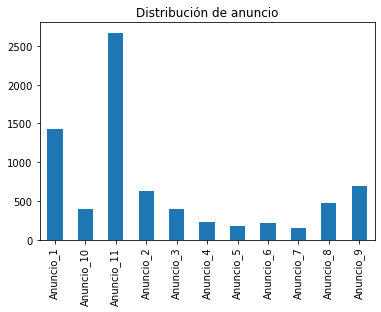

In [172]:
print(df.anuncio.value_counts())
plt.title('Distribución de anuncio')
df.anuncio.value_counts().sort_index().plot(kind='bar')

### Valores de `ubicacion`.

Buenos Aires, Argentina          5183
Cordoba, Argentina                616
Rosario, Argentina                536
Mendoza, Argentina                272
Paraná, Argentina                 248
Tucumán, Argentina                153
ParanÃ¡, Argentina                 98
Neuquén, Argentina                 96
Comodoro Rivadavia, Argentina      81
San Juan, Argentina                77
TucumÃ¡n, Argentina                73
NeuquÃ©n, Argentina                34
Name: ubicacion, dtype: int64


<AxesSubplot:title={'center':'Distribución de ubicacion'}>

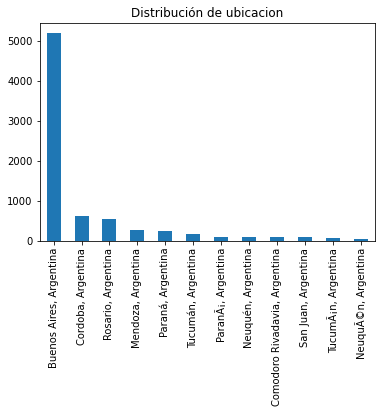

In [173]:
print(df.ubicacion.value_counts())
plt.title('Distribución de ubicacion')
df.ubicacion.value_counts().plot(kind='bar')

### Valores de `fecha`.

2020-08-14    2671
2020-03-19    1422
2020-07-17     694
2020-03-29     631
2020-06-26     474
2020-04-10     399
2020-07-31     396
2020-04-25     232
2020-05-23     217
2020-05-08     177
2020-06-04     150
2020-06-03       1
2020-08-25       1
2020-05-15       1
2020-08-30       1
Name: fecha, dtype: int64


<AxesSubplot:title={'center':'Distribución de fechas'}>

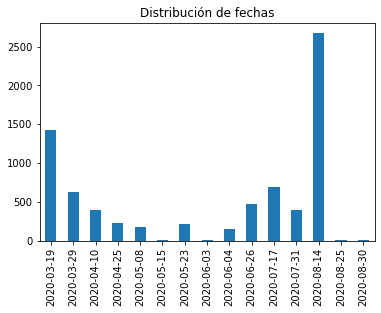

In [174]:
print(df['fecha'].map(lambda x: str(x)[:-15]).value_counts())
plt.title('Distribución de fechas')
df['fecha'].map(lambda x: str(x)[:-15]).value_counts().sort_index().plot(kind='bar')

Para poder aprovechar las funcionalidades después, es conveniente convertir el campo "fecha" en timestamp.

In [175]:
df['fecha'] = pd.to_datetime(df['fecha'])

### Valores de `tweet`.

Procedemos a chusmear los valores de los tweets.

In [184]:
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_colwidth', 130)
df.tweet.sample(50)

887     tenemos 1 dengue 2 tuberculosis 3 desnutricion 4coronavirus 5 peronismo 6 corrupcion 7 desidia son la 7 plagas argentina nos e...
324     hola espero que hayas iniciado muy bien este viernes te comparto este video con 5 consejos utiles para combatir el coronavirus...
2393                                      con lo del coronavirus podemos decir que las negociaciones por gattoni siguen estando avanzadas
725     noticierodoce salud hablamos con el medico infectologo hugo pizzi sobre los ultimos casos de coronavirus y sobre las vacunas q...
1922    importante sobre el gravisimo error que se esta cometiendo en los paises de occidente de no usar barbijos ya lo he destacado a...
940                  che mi mama es la unica insoportable por el coronavirus prefiero que me agarre asi me aislo de ellamentira ma te amo
448     ejemplo a mi el coronavirus no me va a frenar llego de viaje y salgo a donde me de la gana porque soy malo y no me importa pon...
1814    alferdezprensa buenas noch

In [55]:
pd.reset_option('display.max_rows')
pd.reset_option('display.max_colwidth')

Ahora sí... ¡a trabajar en el modelo!